# **dVRK Instrument Segmentation**
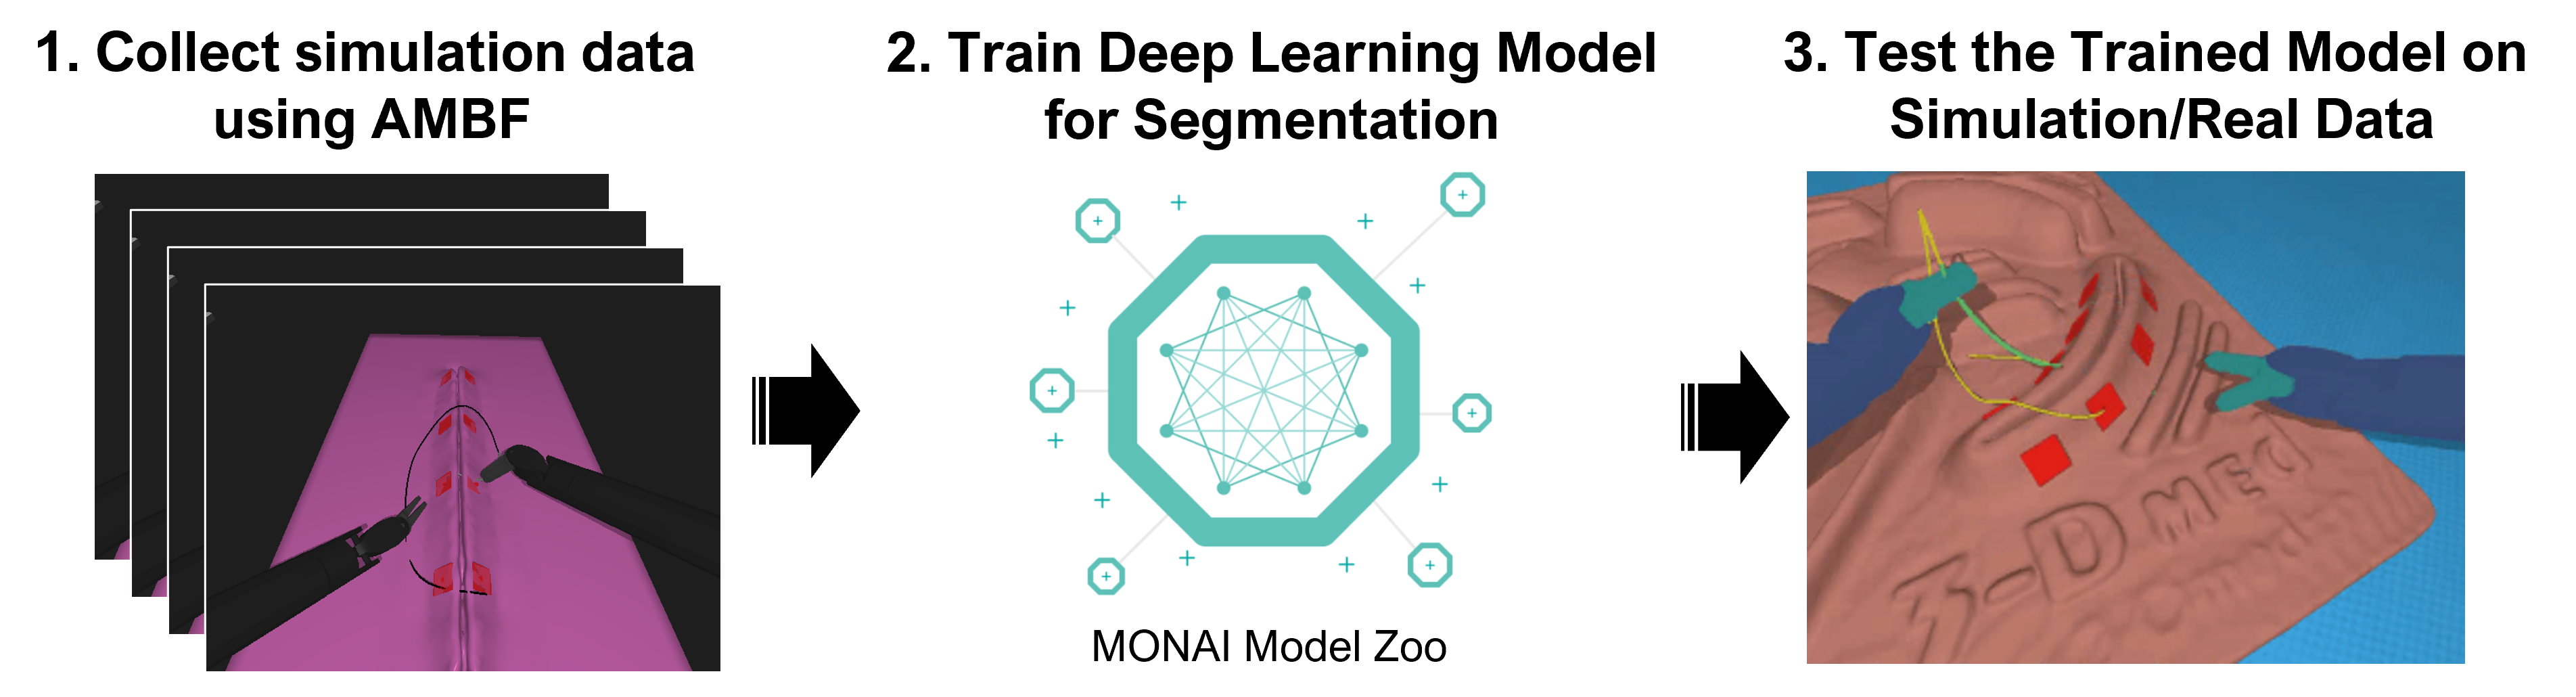
---



Congratulations on successfully collecting the data using AMBF!<br> Now, you've collected the simulation data, we will walk you through the process of training and testing a segmentation model. Even if you haven't collected the data on your own, do not worry; we will provide the data for you. <br>
To run the code blocks below, change the current url ('https://github.com/Accelnet-project-repositories/ISMR_workshop_2023/blob/main/dVRK_Segmentation_Tutorial.ipynb') to 'https://githubtocolab.com/Accelnet-project-repositories/ISMR_workshop_2023/blob/main/dVRK_Segmentation_Tutorial.ipynb' by just adding '**tocolab**' after github. It will bring you to Google Colab.

---




# **Setup**



## 1. Check if you are using GPU
---
The following code should output '/device:GPU:0'. 
If not, go to 'Edit > Notebook settings' and set 'Hardware Accelerator' as 'GPU'.


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

# 2. Load Your Own Data to Colab Session (Optional)
---
First, upload the collected data to your Google Drive. Then, mount your google drive. You would need to grant an access to your google drive data.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Second, upload the data you collected to your Google Drive. Then, copy the data from Drive to Colab Session. 

In [ ]:
!mkdir /content/data
!cp -r /content/drive/PATH/To/DATA1 /content/data/rec01 # Training Data

In [ ]:
!cp -r /content/drive/PATH/To/DATA2 /content/data/rec02 # Validation Data

# 3. Download the assets
If you haven't collect the AMBF data on your own, proceed to download assets from GitHub. <br> 
This also includes the test data and pretrained weights. Thus, please run the following code **even if you have collected the data on your own**.

In [ ]:
!git clone https://github.com/dayon95/AMBFSegmentation.git

# 3. Install MONAI

In [ ]:
!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 45.2 MB/s eta 0:00:00


# 4. Import the required libraries
---
First, change the working directory to the current folder (ISMR23 Workshop)

In [ ]:
#%cd 'drive/Shareddrives/ISMR_workshop/ISMR23'
!git clone https://github.com/Accelnet-project-repositories/dVRK-segmentation-models.git
%cd /content/dVRK-segmentation-models

**Then, import libaries**

In [ ]:
from pathlib import Path
from typing import List, Tuple
import matplotlib.pyplot as plt
from tqdm import trange
import torch
import numpy as np

import monai
from monai.data import ThreadDataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.metrics import DiceMetric, MeanIoU
from monai.networks.nets import FlexibleUNet
import monai.transforms as mt
from monai.visualize.utils import blend_images
from monai.data.video_dataset import VideoFileDataset

from dataclasses import dataclass, field
import pickle
from surg_seg.Trainers.Trainer import ModelTrainer
from surg_seg.Datasets.ImageDataset import ImageSegmentationDataset, ImageTransforms, display_untransformed_images
from surg_seg.Datasets.VideoDatasets2 import CombinedVidDataset, VidDataset, VideoCreator
from surg_seg.Networks.Models import FlexibleUnet1InferencePipe, AbstractInferencePipe
# from ImageDataset import ImageSegmentationDataset, ImageTransforms, display_untransformed_images
# from segmentation_model import  ModelTrainer

# **Load the Data**

In [ ]:
# To load your own data, change the following path to "Your PATH To the Collected Data"
root = Path("/content/AMBFSegmentation/data") 
train_dirs = [root / "rec01"]
val_dirs = [root / "rec02"]
ds = ImageSegmentationDataset(train_dirs, "5colors")
dl = ThreadDataLoader(ds, batch_size=4, num_workers=0, shuffle=True)

val_ds = ImageSegmentationDataset(val_dirs, "5colors")
val_dl = ThreadDataLoader(val_ds, batch_size=4, num_workers=0, shuffle=True)

print(f"Training dataset size: {len(ds)}")
print(f"Validation dataset size: {len(val_ds)}")

Display the data

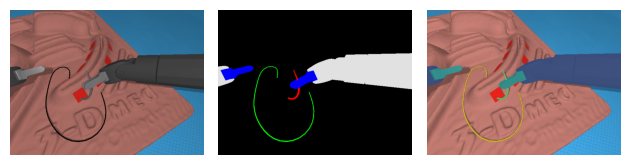

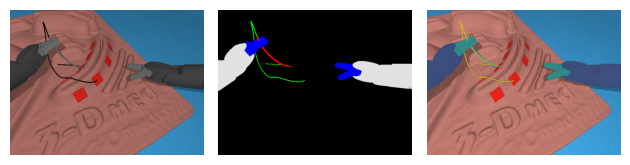

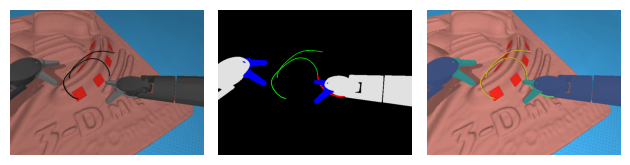

In [ ]:
display_untransformed_images(10, ds)
display_untransformed_images(30, ds)
display_untransformed_images(69, ds)

# **Load pretrained model**

In [ ]:
def create_FlexibleUnet(device, pretrained_weights_path: Path, out_channels: int):

    model = FlexibleUNet(
        in_channels=3,
        out_channels=out_channels,
        backbone="efficientnet-b0",
        pretrained=True,
        is_pad=False,
    ).to(device)

    pretrained_weights = monai.bundle.load(
        name="endoscopic_tool_segmentation", bundle_dir=pretrained_weights_path, version="0.2.0"
    )
    model_weight = model.state_dict()
    weights_no_head = {k: v for k, v in pretrained_weights.items() if not "segmentation_head" in k}
    model_weight.update(weights_no_head)
    model.load_state_dict(model_weight)

    return model

device = "cuda"
pretrained_weights_path = Path("/content/weights/pretrained_weights")
model = create_FlexibleUnet(device, pretrained_weights_path, ds.label_channels)

# **Train the Model**

In [ ]:
## Loading Checkpoints (40 Epochs) ##
checkpoint_path = "/content/AMBFSegmentation/weights/checkpoints2.pt" 
checkpoint = torch.load(checkpoint_path)
optimizer = torch.optim.Adam(model.parameters(), 1e-3) 
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## Train Two More Epochs ##
EPOCH = 2
trainer = ModelTrainer(device=device, max_epochs=EPOCH)
model, training_stats = trainer.train_model(model, optimizer, dl, validation_dl=val_dl)

## Save the Weights ##
model_dir = Path("/content/weights/myweights")
model_dir.mkdir(exist_ok=True)
model_path = model_dir / "myweights.pt"
torch.save(model.state_dict(), model_path)

training_stats.to_pickle(model_dir)
training_stats.plot_stats(file_path=model_dir)

print(f"Last train IOU {training_stats.iou_list[-1]}")
print(f"Last validation IOU {training_stats.validation_iou_list[-1]}")

# **1. Run Inference on Validation Data**

In [ ]:
path_to_weights = Path("/content/weights/myweights/myweights.pt")
model_pipe = FlexibleUnet1InferencePipe(path_to_weights, device, out_channels=5)

def show_inference(ds, model_pipe):
  print(f"Number of frames in dataset: {len(ds)}")
  nrow, ncol = 3, 3
  fig, axes = plt.subplots(nrow, ncol, figsize=(ncol * 3, nrow * 3), facecolor="white")
  nexamples = nrow
  frames = sorted(np.random.choice(len(ds), size=nexamples, replace=False))
  for idx, frame in enumerate(frames):
      ax = axes[idx, :]
      _ds = ds[frame]
      inference = model_pipe.infer_from_transformed_tensor(_ds["image"].to(model_pipe.device))
      inference = inference.detach().cpu()

      # Input Data
      img = _ds["image"]
      np_img = img.permute(1, 2, 0).numpy()
      mina = np.min(np_img)
      maxa = np.max(np_img)
      norm_img = (np_img - mina) / (maxa - mina)
      _img = (norm_img * 254).astype(np.uint8)
      ax[0].imshow(_img)
      ax[0].set_title(f"Frame #: {frame} - Input Data")
      ax[0].axis("off")

      # Inference
      blended = blend_images(img, inference, cmap="viridis", alpha=0.8).numpy()
      blended = (np.transpose(blended, (1, 2, 0)) * 254).astype(np.uint8)
      ax[1].imshow(blended)
      ax[1].set_title(f"Inference Result")
      ax[1].axis("off")

      # Ground truth
      lbl = _ds["label"]
      lbl = torch.argmax(lbl, axis=0)
      lbl = torch.unsqueeze(lbl, 0)
      blended = blend_images(img, lbl, cmap="viridis", alpha=0.8).numpy()
      blended = (np.transpose(blended, (1, 2, 0)) * 254).astype(np.uint8)
      ax[2].imshow(blended)
      ax[2].set_title(f"Ground truth")
      ax[2].axis("off")

  fig.set_tight_layout(True)

  plt.show()

show_inference(val_ds, model_pipe)

# **2. Run Inference on Unseen Data (Simulation)**

In [ ]:
root = Path("/content/AMBFSegmentation/test")
test_dirs = [root / "rec02", root / "rec04"]
test_ds = ImageSegmentationDataset(test_dirs, "5colors")

show_inference(test_ds, model_pipe)

# **3. Run Inference on Real Data**

In [ ]:
from moviepy.editor import *
vid_filepath = Path("/content/AMBFSegmentation/real_data/rec03/2023-04-17_18-34-30_left.avi")
## Play Real Data Video ##
clip=VideoFileClip(vid_filepath)
clip.ipython_display(width=480)

In [ ]:
## Create Inference Video ##
real_ds = VidDataset(vid_filepath)
fps = real_ds.ds_img.get_fps()
print(f"fps {fps}")
video_creator = VideoCreator(fps)

!mkdir /content/inference
output_path = '/content/inference/inferred.mp4'
with torch.no_grad():
    video_creator.create_video(model_pipe, str(output_path), real_ds)

In [ ]:
## Show Inferred Result on Real Video ##
clip=VideoFileClip(output_path)
clip.ipython_display(width=480)